# Telenor Data Science Hackathon

## Team Mango
## Participants:
Mehwish Mujataba

Muaaz Bin Sarfaraz

### Problem Statement
Develop a model to predict potential Non U-Sim customers who is the most likely to opt U-Sim (Upselling). 

### Approach
- Transform and aggregate data at a relevant grain.
- Using a tree based baseline model that is robust against outliers and less sensitive to collinear variables
- Feature selection pipeline
- Feature Engineering
- Re-evaluate hypothesis at each step
- Try different models
- Fine Tune
- Ensemble
- Predict


### Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, make_scorer,confusion_matrix,roc_auc_score,roc_curve,precision_score,recall_score
from sklearn.feature_selection import mutual_info_classif
from sklearn import preprocessing
import operator
from feature_selector import FeatureSelector

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load Dataset

In [21]:
df = pd.read_csv(r'D:\hackathon\Data Sciecne Hackathon Dataset\Training Data.csv', sep =',')

In [30]:
test_set = pd.read_csv(r'D:\hackathon\Data Sciecne Hackathon Dataset\Scoring Data.csv')

In [4]:
df.iloc[:,1:].head()

,TARGET_FLAG,ACTIVITY_DATE,TOTAL_REV,TOTAL_SUBSCRIPTION_REV,VOICE_SUBS_REV,SMS_SUBS_REV,GPRS_SUB_REV,HYBRID_SUB_REV,VAS_SUB_REV,U_OB_VC_CNT_T6,...,FINANCIAL_APP_HITS,VOIP_APP_HITS,EMAIL_APP_HITS,GAME_APP_HITS,MAP_NAVIGATION_APP_HITS,READ_APP_HITS,VIDEO_APP_HITS,P2P_APP_HITS,AUDIO_APP_HITS,APPS_DOWNLOAD_APP_HITS
0,1,6/1/2018,50.6684,9.2,8.0,0.0,0.0,0.0,1.2,25.0,...,0,0,0,0,0,0,0,0,0,0
1,1,6/2/2018,34.7004,9.2,8.0,0.0,0.0,0.0,19.7,12.0,...,0,0,0,0,0,0,0,0,0,0
2,1,6/3/2018,9.4884,9.2,8.0,0.0,0.0,0.0,1.2,10.0,...,0,0,0,0,0,0,0,0,0,0
3,1,6/4/2018,1.2224,1.2,0.0,0.0,0.0,0.0,1.2,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,6/5/2018,13.0994,12.2,0.0,11.0,0.0,0.0,1.2,0.0,...,0,0,0,0,0,0,0,0,0,0


### Check for missing values

In [4]:
missingvalues_col =[] #creating empty list
for i in range(238):
    if  df.iloc[:,i].count()< (len(df.index)*0.99): #if count of values in the column is less than 30% of total row count
        missingvalues_col.append(i)
print (missingvalues_col) #column index where missing values are more than 7

[204]


In [16]:
df.columns[204]

'CITY'

In [18]:
df.CITY.count()

556843

In [22]:
df['CITY_2'] = df['CITY']
cols_to_transform = ['CITY_2']
df=pd.get_dummies(df,columns = cols_to_transform );

### Data Transformation

In [23]:
### Date field transform (Pick days only - since month and year are static)
df['ACTIVITY_DATE'] = pd.to_datetime(df['ACTIVITY_DATE'] , errors='coerce')
df['DAY'] = df['ACTIVITY_DATE'].dt.day.astype('int64')
df.head()

,IDENTITY_ID,TARGET_FLAG,ACTIVITY_DATE,TOTAL_REV,TOTAL_SUBSCRIPTION_REV,VOICE_SUBS_REV,SMS_SUBS_REV,GPRS_SUB_REV,HYBRID_SUB_REV,VAS_SUB_REV,...,CITY_2_THARPARKAR,CITY_2_THATTA,CITY_2_TOBA TEK SINGH,CITY_2_UMARKOT,CITY_2_UPPER DIR,CITY_2_VIHARI,CITY_2_WASHUK,CITY_2_ZHOB,CITY_2_ZIARAT,DAY
0,29,1,2018-06-01,50.6684,9.2,8.0,0.0,0.0,0.0,1.2,...,0,0,0,0,0,0,0,0,0,1
1,29,1,2018-06-02,34.7004,9.2,8.0,0.0,0.0,0.0,19.7,...,0,0,0,0,0,0,0,0,0,2
2,29,1,2018-06-03,9.4884,9.2,8.0,0.0,0.0,0.0,1.2,...,0,0,0,0,0,0,0,0,0,3
3,29,1,2018-06-04,1.2224,1.2,0.0,0.0,0.0,0.0,1.2,...,0,0,0,0,0,0,0,0,0,4
4,29,1,2018-06-05,13.0994,12.2,0.0,11.0,0.0,0.0,1.2,...,0,0,0,0,0,0,0,0,0,5


In [24]:
# activity_date and CITY categorized as object in Python- would drop date since I have day that captures the essence
df.drop(['ACTIVITY_DATE'], axis=1,inplace = True)

In [25]:
df.set_index('IDENTITY_ID',inplace = True)
columns_values = list(df)
columns_values.remove('CITY')
columns_values.remove('DAY')
df.head()

,TARGET_FLAG,TOTAL_REV,TOTAL_SUBSCRIPTION_REV,VOICE_SUBS_REV,SMS_SUBS_REV,GPRS_SUB_REV,HYBRID_SUB_REV,VAS_SUB_REV,U_OB_VC_CNT_T6,U_OB_VC_CC_CNT_T6,...,CITY_2_THARPARKAR,CITY_2_THATTA,CITY_2_TOBA TEK SINGH,CITY_2_UMARKOT,CITY_2_UPPER DIR,CITY_2_VIHARI,CITY_2_WASHUK,CITY_2_ZHOB,CITY_2_ZIARAT,DAY
IDENTITY_ID,,,,,,,,,,,,,,,,,,,,,
29,1,50.6684,9.2,8.0,0.0,0.0,0.0,1.2,25.0,12.0,...,0,0,0,0,0,0,0,0,0,1
29,1,34.7004,9.2,8.0,0.0,0.0,0.0,19.7,12.0,9.0,...,0,0,0,0,0,0,0,0,0,2
29,1,9.4884,9.2,8.0,0.0,0.0,0.0,1.2,10.0,8.0,...,0,0,0,0,0,0,0,0,0,3
29,1,1.2224,1.2,0.0,0.0,0.0,0.0,1.2,0.0,0.0,...,0,0,0,0,0,0,0,0,0,4
29,1,13.0994,12.2,0.0,11.0,0.0,0.0,1.2,0.0,0.0,...,0,0,0,0,0,0,0,0,0,5


In [26]:
#aggregating numerical features 
df_agg = pd.pivot_table(df,index=['IDENTITY_ID'],
                   values =columns_values,
                   aggfunc=[np.sum],fill_value=0)
df_agg.columns = df_agg.columns.droplevel()
#readjustthe target flag after agg summed all to 30
df_agg.TARGET_FLAG = df_agg.TARGET_FLAG//30
df_agg.head()

,ANTIVIRUS_APP_HITS,ANTIVIRUS_APP_VOLUME,APPS_DOWNLOAD_APP_HITS,APPS_DOWNLOAD_APP_VOLUME,AUDIO_APP_HITS,AUDIO_APP_VOLUME,Arts_and_Entertainment_Hits,Arts_and_Entertainment_volume,Autos_and_Vehicles_Hits,Autos_and_Vehicles_volume,...,U_OB_W_VC_REV_T6,U_WAP_CNT_T6,VAS_SUB_REV,VIDEO_APP_HITS,VIDEO_APP_VOLUME,VOICE_SUBS_REV,VOIP_APP_HITS,VOIP_APP_VOLUME,WEBBROWSING_APP_HITS,WEBBROWSING_APP_VOLUME
IDENTITY_ID,,,,,,,,,,,,,,,,,,,,,
29,0,0.0,0,0.0000,0,0.0,0,0.0,0,0.0,...,149.862,0,110.0,0,0.000000e+00,168.0,0,0.0000,0,0.0000
91,0,0.0,15,51592.3282,0,0.0,0,0.0,0,0.0,...,72.157,0,0.0,133,5.785929e+05,0.0,4,48.0244,4085,245475.2366
131,0,0.0,11,51059.0030,0,0.0,0,0.0,0,0.0,...,95.908,0,18.5,2,2.665342e+02,1.0,2,7.0518,478,16817.6395
167,0,0.0,24,215155.8692,0,0.0,0,0.0,0,0.0,...,74.836,0,231.1,216,1.609601e+06,0.0,75,28839.6993,13715,275498.7471
214,0,0.0,0,0.0000,0,0.0,0,0.0,0,0.0,...,14.818,0,50.2,0,0.000000e+00,0.0,0,0.0000,0,0.0000


In [27]:
#aggregative nominal feature (city)
from statistics import mode
df_agg_2 = pd.pivot_table(df,index=['IDENTITY_ID'],
                   values =['CITY'],
                   aggfunc=lambda x: x.mode()[0] if len(x.mode())>1  else x.mode() ,fill_value = 0)

df_agg_2.head()

,CITY
IDENTITY_ID,
29,MUZAFFARABAD
91,MUSAKHEL
131,MARDAN
167,FAISALABAD
214,MULTAN


In [28]:
#inner join two frames
merged = pd.merge(left=df_agg, left_index=True,
                  right=df_agg_2, right_index=True,
                  how='inner')
merged.head()
#merged.to_csv(r'D:\hackathon\Data Sciecne Hackathon Dataset\merged.csv')

,ANTIVIRUS_APP_HITS,ANTIVIRUS_APP_VOLUME,APPS_DOWNLOAD_APP_HITS,APPS_DOWNLOAD_APP_VOLUME,AUDIO_APP_HITS,AUDIO_APP_VOLUME,Arts_and_Entertainment_Hits,Arts_and_Entertainment_volume,Autos_and_Vehicles_Hits,Autos_and_Vehicles_volume,...,U_WAP_CNT_T6,VAS_SUB_REV,VIDEO_APP_HITS,VIDEO_APP_VOLUME,VOICE_SUBS_REV,VOIP_APP_HITS,VOIP_APP_VOLUME,WEBBROWSING_APP_HITS,WEBBROWSING_APP_VOLUME,CITY
IDENTITY_ID,,,,,,,,,,,,,,,,,,,,,
29,0,0.0,0,0.0000,0,0.0,0,0.0,0,0.0,...,0,110.0,0,0.000000e+00,168.0,0,0.0000,0,0.0000,MUZAFFARABAD
91,0,0.0,15,51592.3282,0,0.0,0,0.0,0,0.0,...,0,0.0,133,5.785929e+05,0.0,4,48.0244,4085,245475.2366,MUSAKHEL
131,0,0.0,11,51059.0030,0,0.0,0,0.0,0,0.0,...,0,18.5,2,2.665342e+02,1.0,2,7.0518,478,16817.6395,MARDAN
167,0,0.0,24,215155.8692,0,0.0,0,0.0,0,0.0,...,0,231.1,216,1.609601e+06,0.0,75,28839.6993,13715,275498.7471,FAISALABAD
214,0,0.0,0,0.0000,0,0.0,0,0.0,0,0.0,...,0,50.2,0,0.000000e+00,0.0,0,0.0000,0,0.0000,MULTAN


In [31]:
#City is a nominal feature so label encoding it
le = preprocessing.LabelEncoder()
all_df =pd.DataFrame()
all_df['CITY'] = pd.concat([df['CITY'], test_set['CITY'],merged['CITY']])
all_df.fillna(0)
le.fit(all_df['CITY'].astype(str))
merged['CITY'] = le.transform(merged['CITY'].astype(str))

In [ ]:
g = sns.pairplot(merged.iloc[:,:100], hue='TARGET_FLAG')

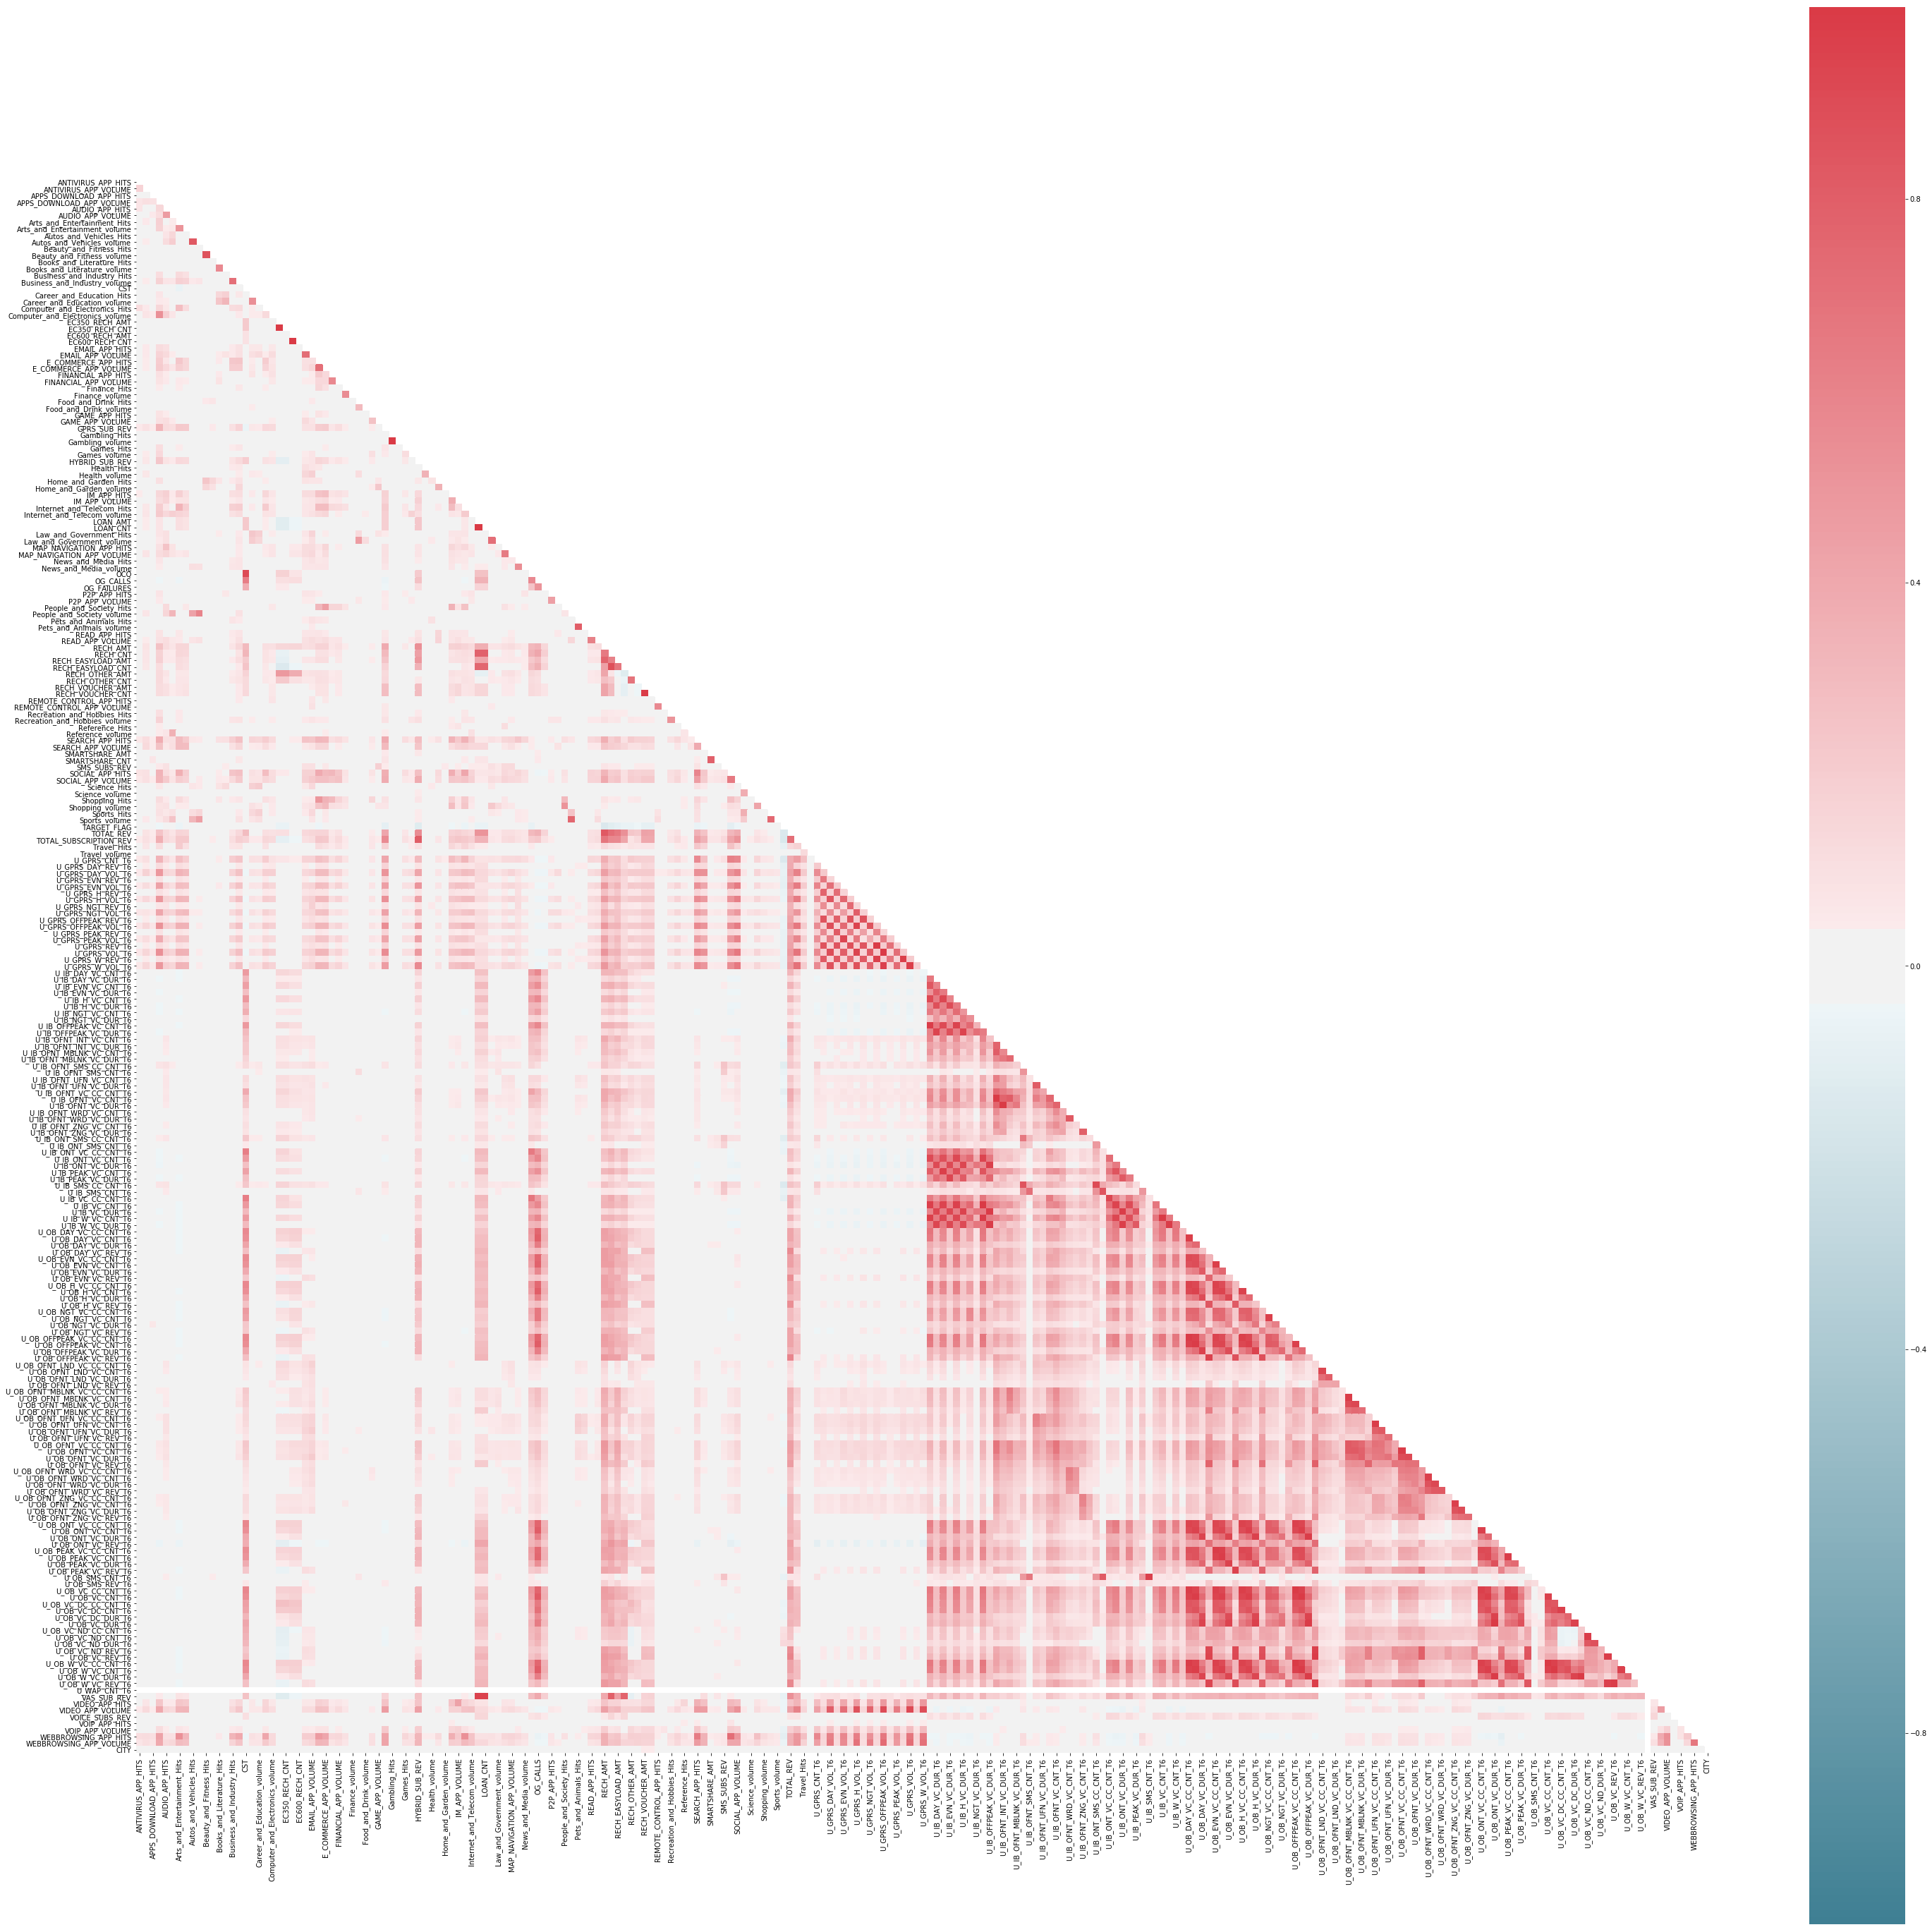

In [86]:
# Compute the correlation matrix
corr = merged.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50,50 ))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0,center=0,
            square=True)

### Baseline Model

Train Test Split

In [32]:
xtrain.shape

(480000, 235)

RF basic model with no feature selection (baseline a model) - aggregated monthly grain

Because we know from the 1st experiment daily grain was not very efficient in finding the pattern

In [41]:
columns_values.remove('TARGET_FLAG')
features = merged[columns_values]
labels = merged['TARGET_FLAG']
xtrain,  xtest,  ytrain,  ytest  = \
train_test_split(features, labels, train_size=0.80, random_state=12)

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [42]:
xtrain.shape

(16000, 364)

In [44]:
scorer = make_scorer(roc_auc_score, average='micro') # F1-measure captures the essence of both precision and recall
forest = RandomForestClassifier()
#tuned_parameters = [{'n_estimators': [500,1000], 'max_features': ['auto', 'none']}]
tuned_parameters = [{'n_estimators': [100],'max_features': ['sqrt']}]
clf = GridSearchCV(forest,tuned_parameters,scoring=scorer, cv=10)
clf.fit(xtrain, ytrain)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

Best parameters set found on development set:

{'max_features': 'sqrt', 'n_estimators': 100}
Grid scores on development set:

0.794 (+/-0.017) for {'max_features': 'sqrt', 'n_estimators': 100}



In [45]:
ypred = clf.predict(xtest)
score = roc_auc_score(ypred,ytest)
print('AUC:', score)

AUC: 0.8222987205405236


Conclusion: Decision to use a monthly aggregation and having one row per subscriber ia a better decision based on the results shown above. Monthly grain showed an AUC score of 0.793 while daily grain had an auc at 0.624

With baseline model we are at an AUC of 0.79

Now time to try feature selection and improve the model building approach

### Feature Selection

Would apply for following techniques for feature selection:
+ Missing values

Drop features below certain missing value threshold

+ Corrleation

Drop features higher than certain correlation threshold(keeping one from the pair)

+ Univariate Features

Drop features that only have one value in the dataset thus play no role in learning and are of zero importance.

+ Feature Importance

Drop features that are of low importance based on a tree model

In [18]:
# slicing transformed data frame for using it with featureselctor
merged_2 = merged
merged_2_labels = merged['TARGET_FLAG']

merged_2= merged_2.drop(columns = ['TARGET_FLAG'])

# using a standard featureselctor python library from https://github.com/WillKoehrsen/feature-selector
fs = FeatureSelector(data = merged_2, labels = merged_2_labels )

#### 1. Missing Values

In [20]:
fs.identify_missing(missing_threshold=0.99)

0 features with greater than 0.99 missing values.



No columns with missing values :)

#### 2. Univariate Features

In [21]:
fs.identify_single_unique()

1 features with a single unique value.



In [23]:
single_unique = fs.ops['single_unique']
single_unique

['U_WAP_CNT_T6']

Since it has no variance (only contains a single value through out the frame it has no learning potential. Would drop this feature

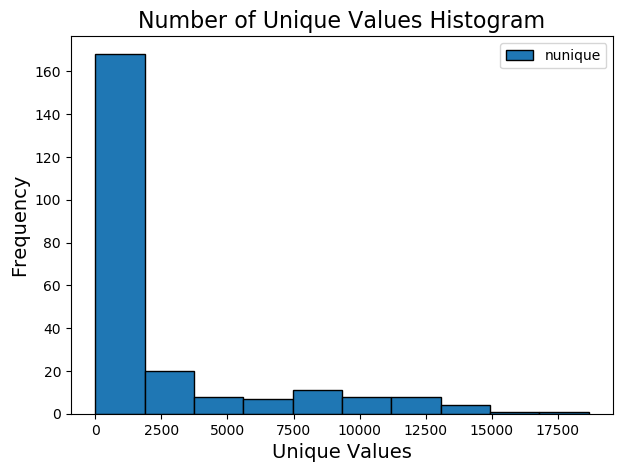

In [24]:
fs.plot_unique()

In [25]:
fs.unique_stats.sample(5)

,nunique
U_IB_VC_DUR_T6,1631
U_OB_PEAK_VC_CNT_T6,247
U_OB_OFNT_LND_VC_DUR_T6,137
U_OB_VC_ND_DUR_T6,1546
Science_volume,131


#### 3. Collinear (highly correlated) Features

This method finds pairs of collinear features based on the Pearson correlation coefficient. For each pair above the specified threshold (in terms of absolute value), it identifies one of the variables to be removed. We need to pass in a correlation_threshold.

In [26]:
fs.identify_collinear(correlation_threshold=0.95)

51 features with a correlation magnitude greater than 0.95.



a heatmap of the correlations above the threhold. The features which will be dropped are on the x-axis.
One of the correlated features would be droped since only the other one is need to learn the behaviour

In [34]:
fs.record_collinear.head(10)

,corr_feature,corr_value,drop_feature
0,EC350_RECH_AMT,1.000000,EC350_RECH_CNT
1,EC600_RECH_AMT,1.000000,EC600_RECH_CNT
2,Gambling_Hits,0.999118,Gambling_volume
3,LOAN_AMT,1.000000,LOAN_CNT
4,RECH_VOUCHER_AMT,0.990428,RECH_VOUCHER_CNT
5,U_GPRS_OFFPEAK_REV_T6,0.990855,U_GPRS_REV_T6
6,U_GPRS_OFFPEAK_VOL_T6,0.993472,U_GPRS_VOL_T6
7,U_GPRS_OFFPEAK_REV_T6,0.963312,U_GPRS_W_REV_T6
8,U_GPRS_REV_T6,0.971491,U_GPRS_W_REV_T6
9,U_GPRS_OFFPEAK_VOL_T6,0.959897,U_GPRS_W_VOL_T6


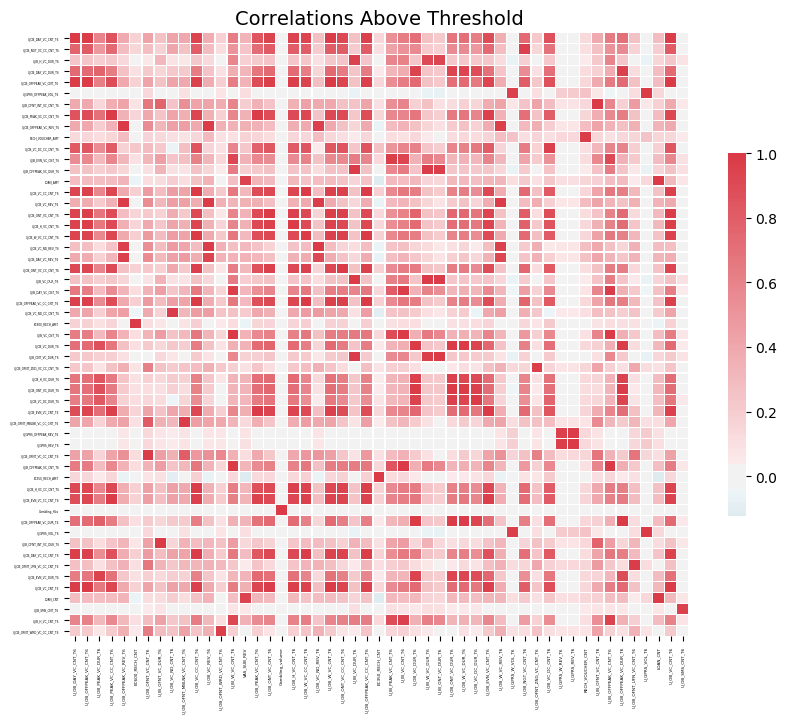

In [28]:
fs.plot_collinear()

#### 4. Zero Importance Features

The method works by finding feature importances using a gradient boosting machine implemented in the LightGBM library.

To reduce variance in the calculated feature importances, the model is trained a default 10 times. The model is also by default trained with early stopping using a validation set (15% of the training data) to identify the optimal number of estimators to train. The following parameters can be passed to the identify_zero_importance method:

+ task: either classification or regression. The metric and labels must match with the task
+ eval_metric: the metric used for early stopping (for example auc for classification or l2 for regression). To see a list of available metrics, refer to the LightGBM docs
+ n_iterations: number of training runs. The feature importances are averaged over the training runs (default = 10)
+ early_stopping: whether to use early stopping when training the model (default = True). Early stopping stops training estimators (decision trees) when the performance on a validation set no longer decreases for a specified number of estimators (100 by default in this implementation). Early stopping is a form of regularization used to prevent overfitting to training data

The data is first one-hot encoded for use in the model. This means that some of the zero importance features may be created from one-hot encoding. To view the one-hot encoded columns, we can access the one_hot_features of the FeatureSelector.

Note of caution: in contrast to the other methods, the feature imporances from a model are non-deterministic (have a little randomness). The results of running this method can change each time it is run.

In [35]:
# using auc metric
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[84]	valid_0's auc: 0.857175
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's auc: 0.843454
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[88]	valid_0's auc: 0.867033
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[206]	valid_0's auc: 0.847183
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[109]	valid_0's auc: 0.853085
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's auc: 0.861261
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[136]	valid_0's auc: 0.860211
Training until validation scores don't improve for 100 rounds.
Early stopp

In [37]:
zero_importance_features  = fs.ops['zero_importance']
zero_importance_features[10:15]

['REMOTE_CONTROL_APP_HITS',
 'Pets_and_Animals_Hits',
 'EC600_RECH_CNT',
 'Gambling_volume',
 'Sports_Hits']

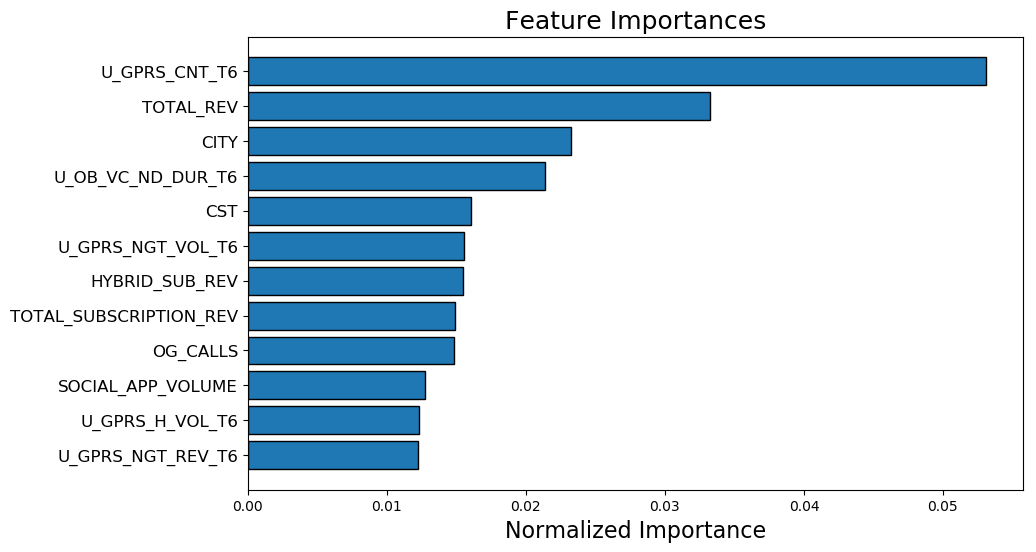

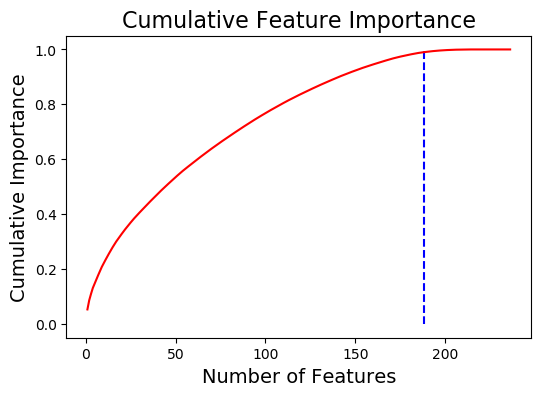

188 features required for 0.99 of cumulative importance


In [38]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [39]:
merged_removed_all = fs.remove(methods = 'all', keep_one_hot=False)

['missing', 'single_unique', 'collinear', 'zero_importance'] methods have been run

Removed 66 features including one-hot features.


In [40]:
print('Original Number of Features', merged_2.shape[1])
print('Final Number of Features: ', merged_removed_all.shape[1])

Original Number of Features 236
Final Number of Features:  170


## More Data Viz

Text(0.5,1,'Total Subscription Revenue')

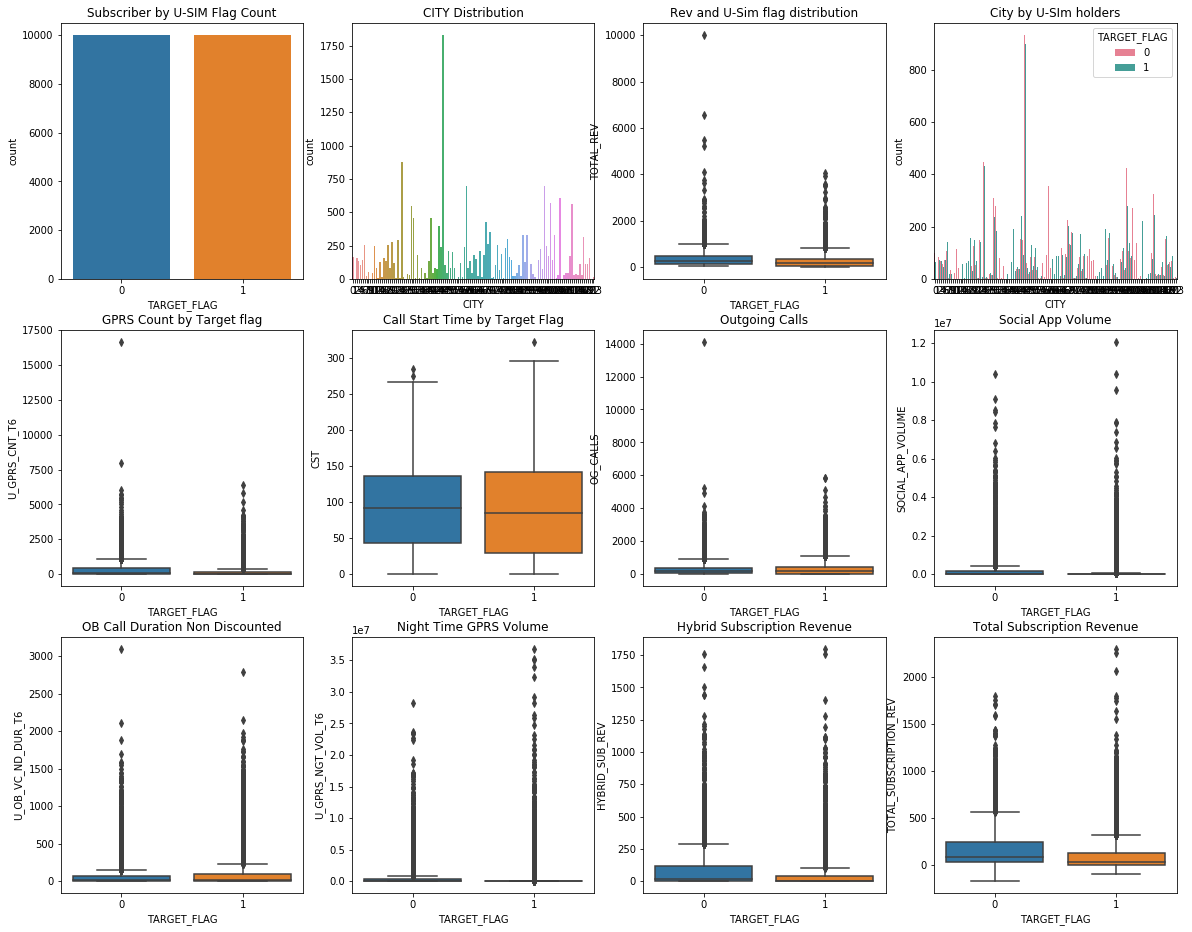

In [16]:
f,ax = plt.subplots(3,4,figsize=(20,16))
sns.countplot('TARGET_FLAG',data=merged,ax=ax[0,0])
sns.countplot('CITY',data=merged,ax=ax[0,1])
sns.boxplot(x='TARGET_FLAG',y='TOTAL_REV',data=merged,ax=ax[0,2])
sns.countplot('CITY',hue='TARGET_FLAG',data=merged,ax=ax[0,3],palette='husl')

sns.boxplot(x='TARGET_FLAG',y='U_GPRS_CNT_T6',data=merged,ax=ax[1,0])
sns.boxplot(x='TARGET_FLAG',y='CST',data=merged,ax=ax[1,1])
sns.boxplot(x='TARGET_FLAG',y='OG_CALLS',data=merged,ax=ax[1,2])
sns.boxplot(x='TARGET_FLAG',y='SOCIAL_APP_VOLUME',data=merged,ax=ax[1,3])

sns.boxplot(x='TARGET_FLAG',y='U_OB_VC_ND_DUR_T6',data=merged,ax=ax[2,0])
sns.boxplot(x='TARGET_FLAG',y='U_GPRS_NGT_VOL_T6',data=merged,ax=ax[2,1])
sns.boxplot(x='TARGET_FLAG',y='HYBRID_SUB_REV',data=merged,ax=ax[2,2])
sns.boxplot(x='TARGET_FLAG',y='TOTAL_SUBSCRIPTION_REV',data=merged,ax=ax[2,3])


ax[0,0].set_title('Subscriber by U-SIM Flag Count')
ax[0,1].set_title('CITY Distribution')
ax[0,2].set_title('Rev and U-Sim flag distribution')
ax[0,3].set_title('City by U-SIm holders')

ax[1,0].set_title('GPRS Count by Target flag')
ax[1,1].set_title('Call Start Time by Target Flag')
ax[1,2].set_title('Outgoing Calls')
ax[1,3].set_title('Social App Volume')

ax[2,0].set_title('OB Call Duration Non Discounted')
ax[2,1].set_title('Night Time GPRS Volume')
ax[2,2].set_title('Hybrid Subscription Revenue')
ax[2,3].set_title('Total Subscription Revenue')

## Re- Modeling with Feature Selection

In [41]:
features = merged_removed_all
labels = merged_2_labels
xtrain,  xtest,  ytrain,  ytest  = \
train_test_split(features, labels, train_size=0.80, random_state=12)

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [42]:
# lets have a better estimation of auc with more folds in cross validation

scorer = make_scorer(roc_auc_score, average='micro') # F1-measure captures the essence of both precision and recall
forest = RandomForestClassifier()
#tuned_parameters = [{'n_estimators': [500,1000], 'max_features': ['auto', 'none']}]
tuned_parameters = [{'n_estimators': [100],'max_features': ['sqrt']}]
clf = GridSearchCV(forest,tuned_parameters,scoring=scorer, cv=10)
clf.fit(xtrain, ytrain)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

Best parameters set found on development set:

{'max_features': 'sqrt', 'n_estimators': 100}
Grid scores on development set:

0.795 (+/-0.017) for {'max_features': 'sqrt', 'n_estimators': 100}



Conclusion: The features removed were of no importance as we are still able to acheive similar results without them.

### My Pipeline -I

For feature selection optimization
No feature engineering was done at this stage

In [21]:
merged_2 = merged
merged_2_labels = merged['TARGET_FLAG']

merged_2= merged_2.drop(columns = ['TARGET_FLAG'])

corrs = [0.7,0.8,0.9,0.95,0.97]
cum_imps =[0.7,0.8,0.9,0.95,0.99]
# using a standard featureselctor python library from https://github.com/WillKoehrsen/feature-selector
for _,corr in enumerate(corrs):
    for _,cum_imp in enumerate(cum_imps):
        print(corr)
        print(cum_imp)
        fs = FeatureSelector(data = merged_2, labels = merged_2_labels )

        fs.identify_all(selection_params = {'missing_threshold':0.99,'correlation_threshold': corr, 
                                            'task': 'classification', 'eval_metric': 'auc', 
                                             'cumulative_importance': cum_imp})
        merged_removed_all = fs.remove(methods = 'all', keep_one_hot = True)

        features = merged_removed_all
        labels = merged_2_labels
        xtrain,  xtest,  ytrain,  ytest  = \
        train_test_split(features, labels, train_size=0.80, random_state=12)

        scorer = make_scorer(roc_auc_score, average='micro') # F1-measure captures the essence of both precision and recall
        forest = RandomForestClassifier()
        #tuned_parameters = [{'n_estimators': [500,1000], 'max_features': ['auto', 'none']}]
        tuned_parameters = [{'n_estimators': [100],'max_features': ['sqrt']}]
        clf = GridSearchCV(forest,tuned_parameters,scoring=scorer, cv=10)
        clf.fit(xtrain, ytrain)
        print('corr:',corr,'   cum_imps:',cum_imp)
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                      % (mean, std * 2, params))
            print()
        print()

0.7
0.7
0 features with greater than 0.99 missing values.

1 features with a single unique value.

123 features with a correlation magnitude greater than 0.70.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[376]	valid_0's auc: 0.853368
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[83]	valid_0's auc: 0.852831
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[202]	valid_0's auc: 0.855101
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[225]	valid_0's auc: 0.869574
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[133]	valid_0's auc: 0.852703
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[162]	valid_0's auc: 0.854736
Training until validation scores don't

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.7    cum_imps: 0.7
0.776 (+/-0.018) for {'max_features': 'sqrt', 'n_estimators': 100}


0.7
0.8
0 features with greater than 0.99 missing values.

1 features with a single unique value.

123 features with a correlation magnitude greater than 0.70.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[194]	valid_0's auc: 0.868889
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[164]	valid_0's auc: 0.855803
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[171]	valid_0's auc: 0.856267
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's auc: 0.844096
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[217]	valid_0's auc: 0.861815
Training until validation scores don't improve for 100 rounds.
Early s

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.7    cum_imps: 0.8
0.777 (+/-0.021) for {'max_features': 'sqrt', 'n_estimators': 100}


0.7
0.9
0 features with greater than 0.99 missing values.

1 features with a single unique value.

123 features with a correlation magnitude greater than 0.70.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[172]	valid_0's auc: 0.855538
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[222]	valid_0's auc: 0.863165
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[118]	valid_0's auc: 0.868076
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[202]	valid_0's auc: 0.842395
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[118]	valid_0's auc: 0.855612
Training until validation scores don't improve for 100 rounds.
Early 

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.7    cum_imps: 0.9
0.781 (+/-0.019) for {'max_features': 'sqrt', 'n_estimators': 100}


0.7
0.95
0 features with greater than 0.99 missing values.

1 features with a single unique value.

123 features with a correlation magnitude greater than 0.70.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's auc: 0.857436
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	valid_0's auc: 0.85822
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[186]	valid_0's auc: 0.859833
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's auc: 0.859963
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[95]	valid_0's auc: 0.84899
Training until validation scores don't improve for 100 rounds.
Early stopp

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.7    cum_imps: 0.95
0.782 (+/-0.019) for {'max_features': 'sqrt', 'n_estimators': 100}


0.7
0.99
0 features with greater than 0.99 missing values.

1 features with a single unique value.

123 features with a correlation magnitude greater than 0.70.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[180]	valid_0's auc: 0.858708
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[85]	valid_0's auc: 0.85131
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[244]	valid_0's auc: 0.850918
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[450]	valid_0's auc: 0.852341
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[179]	valid_0's auc: 0.866533
Training until validation scores don't improve for 100 rounds.
Early 

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.7    cum_imps: 0.99
0.782 (+/-0.017) for {'max_features': 'sqrt', 'n_estimators': 100}


0.8
0.7
0 features with greater than 0.99 missing values.

1 features with a single unique value.

94 features with a correlation magnitude greater than 0.80.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[155]	valid_0's auc: 0.852605
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[91]	valid_0's auc: 0.861742
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[102]	valid_0's auc: 0.849199
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[248]	valid_0's auc: 0.863487
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[433]	valid_0's auc: 0.853948
Training until validation scores don't improve for 100 rounds.
Early s

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.8    cum_imps: 0.7
0.779 (+/-0.021) for {'max_features': 'sqrt', 'n_estimators': 100}


0.8
0.8
0 features with greater than 0.99 missing values.

1 features with a single unique value.

94 features with a correlation magnitude greater than 0.80.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	valid_0's auc: 0.857583
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[100]	valid_0's auc: 0.851322
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[93]	valid_0's auc: 0.853469
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[177]	valid_0's auc: 0.858527
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[115]	valid_0's auc: 0.85156
Training until validation scores don't improve for 100 rounds.
Early stop

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.8    cum_imps: 0.8
0.784 (+/-0.017) for {'max_features': 'sqrt', 'n_estimators': 100}


0.8
0.9
0 features with greater than 0.99 missing values.

1 features with a single unique value.

94 features with a correlation magnitude greater than 0.80.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	valid_0's auc: 0.84631
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[89]	valid_0's auc: 0.844719
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[115]	valid_0's auc: 0.843342
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's auc: 0.856045
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[140]	valid_0's auc: 0.862647
Training until validation scores don't improve for 100 rounds.
Early stopp

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.8    cum_imps: 0.9
0.783 (+/-0.020) for {'max_features': 'sqrt', 'n_estimators': 100}


0.8
0.95
0 features with greater than 0.99 missing values.

1 features with a single unique value.

94 features with a correlation magnitude greater than 0.80.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[499]	valid_0's auc: 0.853591
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[157]	valid_0's auc: 0.855907
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's auc: 0.851109
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's auc: 0.861183
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[184]	valid_0's auc: 0.846629
Training until validation scores don't improve for 100 rounds.
Early st

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.8    cum_imps: 0.95
0.783 (+/-0.013) for {'max_features': 'sqrt', 'n_estimators': 100}


0.8
0.99
0 features with greater than 0.99 missing values.

1 features with a single unique value.

94 features with a correlation magnitude greater than 0.80.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	valid_0's auc: 0.857678
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[93]	valid_0's auc: 0.861959
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[157]	valid_0's auc: 0.862417
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[135]	valid_0's auc: 0.859595
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[283]	valid_0's auc: 0.847525
Training until validation scores don't improve for 100 rounds.
Early 

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.8    cum_imps: 0.99
0.783 (+/-0.016) for {'max_features': 'sqrt', 'n_estimators': 100}


0.9
0.7
0 features with greater than 0.99 missing values.

1 features with a single unique value.

69 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[207]	valid_0's auc: 0.860221
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[82]	valid_0's auc: 0.853688
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	valid_0's auc: 0.861299
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[126]	valid_0's auc: 0.86193
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[129]	valid_0's auc: 0.859908
Training until validation scores don't improve for 100 rounds.
Early st

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.9    cum_imps: 0.7
0.795 (+/-0.019) for {'max_features': 'sqrt', 'n_estimators': 100}


0.9
0.8
0 features with greater than 0.99 missing values.

1 features with a single unique value.

69 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[239]	valid_0's auc: 0.849496
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[139]	valid_0's auc: 0.853627
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[432]	valid_0's auc: 0.862023
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[199]	valid_0's auc: 0.850669
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[93]	valid_0's auc: 0.854779
Training until validation scores don't improve for 100 rounds.
Early st

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.9    cum_imps: 0.8
0.796 (+/-0.018) for {'max_features': 'sqrt', 'n_estimators': 100}


0.9
0.9
0 features with greater than 0.99 missing values.

1 features with a single unique value.

69 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[68]	valid_0's auc: 0.845341
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[117]	valid_0's auc: 0.855315
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[91]	valid_0's auc: 0.853915
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[111]	valid_0's auc: 0.855105
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[121]	valid_0's auc: 0.850551
Training until validation scores don't improve for 100 rounds.
Early sto

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.9    cum_imps: 0.9
0.796 (+/-0.020) for {'max_features': 'sqrt', 'n_estimators': 100}


0.9
0.95
0 features with greater than 0.99 missing values.

1 features with a single unique value.

69 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[118]	valid_0's auc: 0.846718
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[98]	valid_0's auc: 0.857728
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[77]	valid_0's auc: 0.863276
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[67]	valid_0's auc: 0.849195
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	valid_0's auc: 0.846926
Training until validation scores don't improve for 100 rounds.
Early stop

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.9    cum_imps: 0.95
0.795 (+/-0.019) for {'max_features': 'sqrt', 'n_estimators': 100}


0.9
0.99
0 features with greater than 0.99 missing values.

1 features with a single unique value.

69 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[96]	valid_0's auc: 0.864097
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[210]	valid_0's auc: 0.847907
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[221]	valid_0's auc: 0.850916
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[130]	valid_0's auc: 0.854662
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[459]	valid_0's auc: 0.850119
Training until validation scores don't improve for 100 rounds.
Early 

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.9    cum_imps: 0.99
0.793 (+/-0.019) for {'max_features': 'sqrt', 'n_estimators': 100}


0.95
0.7
0 features with greater than 0.99 missing values.

1 features with a single unique value.

51 features with a correlation magnitude greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[256]	valid_0's auc: 0.836773
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[90]	valid_0's auc: 0.862348
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[142]	valid_0's auc: 0.853798
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[110]	valid_0's auc: 0.851158
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[126]	valid_0's auc: 0.854389
Training until validation scores don't improve for 100 rounds.
Early 

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.95    cum_imps: 0.7
0.795 (+/-0.020) for {'max_features': 'sqrt', 'n_estimators': 100}


0.95
0.8
0 features with greater than 0.99 missing values.

1 features with a single unique value.

51 features with a correlation magnitude greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[108]	valid_0's auc: 0.860979
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[116]	valid_0's auc: 0.857922
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[181]	valid_0's auc: 0.848061
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[64]	valid_0's auc: 0.861157
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[86]	valid_0's auc: 0.865363
Training until validation scores don't improve for 100 rounds.
Early s

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.95    cum_imps: 0.8
0.797 (+/-0.016) for {'max_features': 'sqrt', 'n_estimators': 100}


0.95
0.9
0 features with greater than 0.99 missing values.

1 features with a single unique value.

51 features with a correlation magnitude greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[134]	valid_0's auc: 0.847331
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[125]	valid_0's auc: 0.856948
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[84]	valid_0's auc: 0.857446
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[81]	valid_0's auc: 0.862343
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[206]	valid_0's auc: 0.850501
Training until validation scores don't improve for 100 rounds.
Early s

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.95    cum_imps: 0.9
0.794 (+/-0.018) for {'max_features': 'sqrt', 'n_estimators': 100}


0.95
0.95
0 features with greater than 0.99 missing values.

1 features with a single unique value.

51 features with a correlation magnitude greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[143]	valid_0's auc: 0.845448
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[110]	valid_0's auc: 0.859283
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[207]	valid_0's auc: 0.859794
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[194]	valid_0's auc: 0.851894
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[201]	valid_0's auc: 0.842142
Training until validation scores don't improve for 100 rounds.
Earl

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.95    cum_imps: 0.95
0.795 (+/-0.016) for {'max_features': 'sqrt', 'n_estimators': 100}


0.95
0.99
0 features with greater than 0.99 missing values.

1 features with a single unique value.

51 features with a correlation magnitude greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[87]	valid_0's auc: 0.858019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[153]	valid_0's auc: 0.853596
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[148]	valid_0's auc: 0.843274
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[241]	valid_0's auc: 0.867341
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[170]	valid_0's auc: 0.85323
Training until validation scores don't improve for 100 rounds.
Early

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.95    cum_imps: 0.99
0.797 (+/-0.018) for {'max_features': 'sqrt', 'n_estimators': 100}


0.97
0.7
0 features with greater than 0.99 missing values.

1 features with a single unique value.

35 features with a correlation magnitude greater than 0.97.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[118]	valid_0's auc: 0.858176
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[136]	valid_0's auc: 0.860648
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[120]	valid_0's auc: 0.859141
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[101]	valid_0's auc: 0.861667
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[240]	valid_0's auc: 0.8571
Training until validation scores don't improve for 100 rounds.
Early 

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.97    cum_imps: 0.7
0.796 (+/-0.016) for {'max_features': 'sqrt', 'n_estimators': 100}


0.97
0.8
0 features with greater than 0.99 missing values.

1 features with a single unique value.

35 features with a correlation magnitude greater than 0.97.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[167]	valid_0's auc: 0.843194
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[150]	valid_0's auc: 0.860766
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[120]	valid_0's auc: 0.860575
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[109]	valid_0's auc: 0.855486
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[80]	valid_0's auc: 0.852778
Training until validation scores don't improve for 100 rounds.
Early 

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.97    cum_imps: 0.8
0.794 (+/-0.020) for {'max_features': 'sqrt', 'n_estimators': 100}


0.97
0.9
0 features with greater than 0.99 missing values.

1 features with a single unique value.

35 features with a correlation magnitude greater than 0.97.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[144]	valid_0's auc: 0.86571
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[67]	valid_0's auc: 0.862736
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[146]	valid_0's auc: 0.841559
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[134]	valid_0's auc: 0.854271
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[142]	valid_0's auc: 0.859701
Training until validation scores don't improve for 100 rounds.
Early s

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.97    cum_imps: 0.9
0.796 (+/-0.014) for {'max_features': 'sqrt', 'n_estimators': 100}


0.97
0.95
0 features with greater than 0.99 missing values.

1 features with a single unique value.

35 features with a correlation magnitude greater than 0.97.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[281]	valid_0's auc: 0.858223
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[106]	valid_0's auc: 0.841804
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[171]	valid_0's auc: 0.858173
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[69]	valid_0's auc: 0.860579
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[110]	valid_0's auc: 0.862975
Training until validation scores don't improve for 100 rounds.
Early

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.97    cum_imps: 0.95
0.796 (+/-0.018) for {'max_features': 'sqrt', 'n_estimators': 100}


0.97
0.99
0 features with greater than 0.99 missing values.

1 features with a single unique value.

35 features with a correlation magnitude greater than 0.97.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[107]	valid_0's auc: 0.843203
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[175]	valid_0's auc: 0.85885
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[165]	valid_0's auc: 0.850877
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[69]	valid_0's auc: 0.851592
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	valid_0's auc: 0.858969
Training until validation scores don't improve for 100 rounds.
Early 

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.97    cum_imps: 0.99
0.796 (+/-0.018) for {'max_features': 'sqrt', 'n_estimators': 100}




corr: 0.95    cum_imps: 0.99
0.797 (+/-0.018) for {'max_features': 'sqrt', 'n_estimators': 100}


corr: 0.95    cum_imps: 0.8
0.797 (+/-0.016) for {'max_features': 'sqrt', 'n_estimators': 100}






### Feature Engineering

In [166]:
# clubbing hits and volume to one column to switch from sparse to dense matrix
col_to_use_vol = ['Finance_volume',
'Arts_and_Entertainment_volume',
'Autos_and_Vehicles_volume',
'Beauty_and_Fitness_volume',
'Books_and_Literature_volume',
'Business_and_Industry_volume',
'Career_and_Education_volume',
'Computer_and_Electronics_volume',
'Food_and_Drink_volume',
'Gambling_volume',
'Games_volume',
'Health_volume',
'Home_and_Garden_volume',
'Internet_and_Telecom_volume',
'Law_and_Government_volume',
'News_and_Media_volume',
'Health_volume',
'People_and_Society_volume',
'Pets_and_Animals_volume',
'Recreation_and_Hobbies_volume',
'Reference_volume',
'Science_volume',
'Shopping_volume',
'Sports_volume',
'Travel_volume',
'REMOTE_CONTROL_APP_VOLUME',
'IM_APP_VOLUME',
'WEBBROWSING_APP_VOLUME',
'ANTIVIRUS_APP_VOLUME',
'SOCIAL_APP_VOLUME',
'SEARCH_APP_VOLUME',
'FINANCIAL_APP_VOLUME',
'VOIP_APP_VOLUME',
'EMAIL_APP_VOLUME',
'GAME_APP_VOLUME',
'MAP_NAVIGATION_APP_VOLUME',
'READ_APP_VOLUME',
'VIDEO_APP_VOLUME',
'P2P_APP_VOLUME',
'AUDIO_APP_VOLUME',
'APPS_DOWNLOAD_APP_VOLUME',
'E_COMMERCE_APP_VOLUME']

col_to_use_hits = ['Finance_Hits',
'Arts_and_Entertainment_Hits',
'Autos_and_Vehicles_Hits',
'Beauty_and_Fitness_Hits',
'Books_and_Literature_Hits',
'Business_and_Industry_Hits',
'Career_and_Education_Hits',
'Computer_and_Electronics_Hits',
'Food_and_Drink_Hits',
'Gambling_Hits',
'Games_Hits',
'Health_Hits',
'Home_and_Garden_Hits',
'Internet_and_Telecom_Hits',
'Law_and_Government_Hits',
'News_and_Media_Hits',
'Health_Hits',
'People_and_Society_Hits',
'Pets_and_Animals_Hits',
'Recreation_and_Hobbies_Hits',
'Reference_Hits',
'Science_Hits',
'Shopping_Hits',
'Sports_Hits',
'Travel_Hits',
'REMOTE_CONTROL_APP_HITS',
'IM_APP_HITS',
'WEBBROWSING_APP_HITS',
'ANTIVIRUS_APP_HITS',
'SOCIAL_APP_HITS',
'SEARCH_APP_HITS',
'FINANCIAL_APP_HITS',
'VOIP_APP_HITS',
'EMAIL_APP_HITS',
'GAME_APP_HITS',
'MAP_NAVIGATION_APP_HITS',
'READ_APP_HITS',
'VIDEO_APP_HITS',
'P2P_APP_HITS',
'AUDIO_APP_HITS',
'APPS_DOWNLOAD_APP_HITS',
'E_COMMERCE_APP_HITS']


merged['total_vol'] =merged[col_to_use_vol].sum(axis = 1)
merged['total_hits'] =merged[col_to_use_hits].sum(axis = 1)

In [167]:
merged.head()

,ANTIVIRUS_APP_HITS,ANTIVIRUS_APP_VOLUME,APPS_DOWNLOAD_APP_HITS,APPS_DOWNLOAD_APP_VOLUME,AUDIO_APP_HITS,AUDIO_APP_VOLUME,Arts_and_Entertainment_Hits,Arts_and_Entertainment_volume,Autos_and_Vehicles_Hits,Autos_and_Vehicles_volume,...,VIDEO_APP_HITS,VIDEO_APP_VOLUME,VOICE_SUBS_REV,VOIP_APP_HITS,VOIP_APP_VOLUME,WEBBROWSING_APP_HITS,WEBBROWSING_APP_VOLUME,CITY,total_vol,total_hits
IDENTITY_ID,,,,,,,,,,,,,,,,,,,,,
29,0,0.0,0,0.0000,0,0.0,0,0.0,0,0.0,...,0,0.000000e+00,168.0,0,0.0000,0,0.0000,82,0.000000e+00,0
91,0,0.0,15,51592.3282,0,0.0,0,0.0,0,0.0,...,133,5.785929e+05,0.0,4,48.0244,4085,245475.2366,81,1.196228e+06,7126
131,0,0.0,11,51059.0030,0,0.0,0,0.0,0,0.0,...,2,2.665342e+02,1.0,2,7.0518,478,16817.6395,74,9.210379e+04,967
167,0,0.0,24,215155.8692,0,0.0,0,0.0,0,0.0,...,216,1.609601e+06,0.0,75,28839.6993,13715,275498.7471,25,2.535640e+06,27293
214,0,0.0,0,0.0000,0,0.0,0,0.0,0,0.0,...,0,0.000000e+00,0.0,0,0.0000,0,0.0000,80,1.298574e+02,25


### My Pipeline -II
With feature selection and Feature engineering


In [25]:
merged_2 = merged
merged_2_labels = merged['TARGET_FLAG']

merged_2= merged_2.drop(columns = ['TARGET_FLAG'])

corrs = [0.7,0.8,0.9,0.95,0.97]
cum_imps =[0.7,0.8,0.9,0.95,0.99]
# using a standard featureselctor python library from https://github.com/WillKoehrsen/feature-selector
for _,corr in enumerate(corrs):
    for _,cum_imp in enumerate(cum_imps):
        print(corr)
        print(cum_imp)
        fs = FeatureSelector(data = merged_2, labels = merged_2_labels )

        fs.identify_all(selection_params = {'missing_threshold':0.99,'correlation_threshold': corr, 
                                            'task': 'classification', 'eval_metric': 'auc', 
                                             'cumulative_importance': cum_imp})
        merged_removed_all = fs.remove(methods = 'all', keep_one_hot = True)

        features = merged_removed_all
        labels = merged_2_labels
        xtrain,  xtest,  ytrain,  ytest  = \
        train_test_split(features, labels, train_size=0.80, random_state=12)

        scorer = make_scorer(roc_auc_score, average='micro') # F1-measure captures the essence of both precision and recall
        forest = RandomForestClassifier()
        #tuned_parameters = [{'n_estimators': [500,1000], 'max_features': ['auto', 'none']}]
        tuned_parameters = [{'n_estimators': [100],'max_features': ['sqrt']}]
        clf = GridSearchCV(forest,tuned_parameters,scoring=scorer, cv=10)
        clf.fit(xtrain, ytrain)
        print('corr:',corr,'   cum_imps:',cum_imp)
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                      % (mean, std * 2, params))
            print()
        print()

0.7
0.7
0 features with greater than 0.99 missing values.

1 features with a single unique value.

125 features with a correlation magnitude greater than 0.70.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[214]	valid_0's auc: 0.856764
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	valid_0's auc: 0.847428
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[111]	valid_0's auc: 0.867314
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's auc: 0.859501
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[105]	valid_0's auc: 0.84878
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	valid_0's auc: 0.859256
Training until validation scores don't i

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.7    cum_imps: 0.7
0.775 (+/-0.017) for {'max_features': 'sqrt', 'n_estimators': 100}


0.7
0.8
0 features with greater than 0.99 missing values.

1 features with a single unique value.

125 features with a correlation magnitude greater than 0.70.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's auc: 0.860343
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[190]	valid_0's auc: 0.860072
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[172]	valid_0's auc: 0.859543
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[238]	valid_0's auc: 0.853672
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[118]	valid_0's auc: 0.845619
Training until validation scores don't improve for 100 rounds.
Early s

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.7    cum_imps: 0.8
0.780 (+/-0.016) for {'max_features': 'sqrt', 'n_estimators': 100}


0.7
0.9
0 features with greater than 0.99 missing values.

1 features with a single unique value.

125 features with a correlation magnitude greater than 0.70.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[137]	valid_0's auc: 0.85812
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[151]	valid_0's auc: 0.849686
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[96]	valid_0's auc: 0.851862
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[106]	valid_0's auc: 0.864728
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[226]	valid_0's auc: 0.855182
Training until validation scores don't improve for 100 rounds.
Early st

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.7    cum_imps: 0.9
0.784 (+/-0.017) for {'max_features': 'sqrt', 'n_estimators': 100}


0.7
0.95
0 features with greater than 0.99 missing values.

1 features with a single unique value.

125 features with a correlation magnitude greater than 0.70.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[103]	valid_0's auc: 0.849193
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[509]	valid_0's auc: 0.854153
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[204]	valid_0's auc: 0.843277
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[130]	valid_0's auc: 0.85162
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[95]	valid_0's auc: 0.864068
Training until validation scores don't improve for 100 rounds.
Early s

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.7    cum_imps: 0.95
0.782 (+/-0.019) for {'max_features': 'sqrt', 'n_estimators': 100}


0.7
0.99
0 features with greater than 0.99 missing values.

1 features with a single unique value.

125 features with a correlation magnitude greater than 0.70.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[150]	valid_0's auc: 0.847354
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[162]	valid_0's auc: 0.853917
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[86]	valid_0's auc: 0.857664
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[115]	valid_0's auc: 0.855615
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[251]	valid_0's auc: 0.866396
Training until validation scores don't improve for 100 rounds.
Early

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.7    cum_imps: 0.99
0.782 (+/-0.016) for {'max_features': 'sqrt', 'n_estimators': 100}


0.8
0.7
0 features with greater than 0.99 missing values.

1 features with a single unique value.

96 features with a correlation magnitude greater than 0.80.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[94]	valid_0's auc: 0.85322
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[122]	valid_0's auc: 0.833966
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[95]	valid_0's auc: 0.851586
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[130]	valid_0's auc: 0.864207
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[98]	valid_0's auc: 0.862213
Training until validation scores don't improve for 100 rounds.
Early stop

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.8    cum_imps: 0.7
0.779 (+/-0.021) for {'max_features': 'sqrt', 'n_estimators': 100}


0.8
0.8
0 features with greater than 0.99 missing values.

1 features with a single unique value.

96 features with a correlation magnitude greater than 0.80.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[115]	valid_0's auc: 0.851974
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[182]	valid_0's auc: 0.861543
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[335]	valid_0's auc: 0.84907
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[91]	valid_0's auc: 0.855173
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[128]	valid_0's auc: 0.850921
Training until validation scores don't improve for 100 rounds.
Early sto

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.8    cum_imps: 0.8
0.783 (+/-0.013) for {'max_features': 'sqrt', 'n_estimators': 100}


0.8
0.9
0 features with greater than 0.99 missing values.

1 features with a single unique value.

96 features with a correlation magnitude greater than 0.80.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[137]	valid_0's auc: 0.848886
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[103]	valid_0's auc: 0.853897
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[295]	valid_0's auc: 0.86247
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[78]	valid_0's auc: 0.859956
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[31]	valid_0's auc: 0.860124
Training until validation scores don't improve for 100 rounds.
Early stop

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.8    cum_imps: 0.9
0.782 (+/-0.018) for {'max_features': 'sqrt', 'n_estimators': 100}


0.8
0.95
0 features with greater than 0.99 missing values.

1 features with a single unique value.

96 features with a correlation magnitude greater than 0.80.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[157]	valid_0's auc: 0.860966
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[118]	valid_0's auc: 0.853822
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[126]	valid_0's auc: 0.852584
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[91]	valid_0's auc: 0.865
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[179]	valid_0's auc: 0.865909
Training until validation scores don't improve for 100 rounds.
Early stop

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.8    cum_imps: 0.95
0.780 (+/-0.021) for {'max_features': 'sqrt', 'n_estimators': 100}


0.8
0.99
0 features with greater than 0.99 missing values.

1 features with a single unique value.

96 features with a correlation magnitude greater than 0.80.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[203]	valid_0's auc: 0.853133
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[141]	valid_0's auc: 0.865112
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[83]	valid_0's auc: 0.853064
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[269]	valid_0's auc: 0.849482
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[93]	valid_0's auc: 0.853038
Training until validation scores don't improve for 100 rounds.
Early s

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.8    cum_imps: 0.99
0.781 (+/-0.019) for {'max_features': 'sqrt', 'n_estimators': 100}


0.9
0.7
0 features with greater than 0.99 missing values.

1 features with a single unique value.

71 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[100]	valid_0's auc: 0.860479
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[338]	valid_0's auc: 0.858188
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's auc: 0.841957
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[137]	valid_0's auc: 0.850791
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[76]	valid_0's auc: 0.843023
Training until validation scores don't improve for 100 rounds.
Early st

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.9    cum_imps: 0.7
0.796 (+/-0.020) for {'max_features': 'sqrt', 'n_estimators': 100}


0.9
0.8
0 features with greater than 0.99 missing values.

1 features with a single unique value.

71 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[97]	valid_0's auc: 0.85471
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[108]	valid_0's auc: 0.852914
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[238]	valid_0's auc: 0.861186
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[163]	valid_0's auc: 0.84977
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[88]	valid_0's auc: 0.851516
Training until validation scores don't improve for 100 rounds.
Early stopp

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.9    cum_imps: 0.8
0.795 (+/-0.016) for {'max_features': 'sqrt', 'n_estimators': 100}


0.9
0.9
0 features with greater than 0.99 missing values.

1 features with a single unique value.

71 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[120]	valid_0's auc: 0.851651
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[111]	valid_0's auc: 0.858598
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[136]	valid_0's auc: 0.842613
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[124]	valid_0's auc: 0.861828
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	valid_0's auc: 0.854602
Training until validation scores don't improve for 100 rounds.
Early st

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.9    cum_imps: 0.9
0.796 (+/-0.016) for {'max_features': 'sqrt', 'n_estimators': 100}


0.9
0.95
0 features with greater than 0.99 missing values.

1 features with a single unique value.

71 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[141]	valid_0's auc: 0.853025
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[198]	valid_0's auc: 0.857669
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[89]	valid_0's auc: 0.855027
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's auc: 0.856078
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[177]	valid_0's auc: 0.853154
Training until validation scores don't improve for 100 rounds.
Early st

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.9    cum_imps: 0.95
0.796 (+/-0.022) for {'max_features': 'sqrt', 'n_estimators': 100}


0.9
0.99
0 features with greater than 0.99 missing values.

1 features with a single unique value.

71 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[393]	valid_0's auc: 0.851383
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[204]	valid_0's auc: 0.855647
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[156]	valid_0's auc: 0.855976
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's auc: 0.845378
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[80]	valid_0's auc: 0.844038
Training until validation scores don't improve for 100 rounds.
Early s

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.9    cum_imps: 0.99
0.795 (+/-0.014) for {'max_features': 'sqrt', 'n_estimators': 100}


0.95
0.7
0 features with greater than 0.99 missing values.

1 features with a single unique value.

52 features with a correlation magnitude greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[183]	valid_0's auc: 0.839952
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[91]	valid_0's auc: 0.861929
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[104]	valid_0's auc: 0.84769
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[81]	valid_0's auc: 0.861517
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[101]	valid_0's auc: 0.844156
Training until validation scores don't improve for 100 rounds.
Early st

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.95    cum_imps: 0.7
0.796 (+/-0.022) for {'max_features': 'sqrt', 'n_estimators': 100}


0.95
0.8
0 features with greater than 0.99 missing values.

1 features with a single unique value.

52 features with a correlation magnitude greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[264]	valid_0's auc: 0.856401
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[200]	valid_0's auc: 0.853371
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[100]	valid_0's auc: 0.858686
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[237]	valid_0's auc: 0.84037
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[206]	valid_0's auc: 0.853165
Training until validation scores don't improve for 100 rounds.
Early 

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.95    cum_imps: 0.8
0.796 (+/-0.019) for {'max_features': 'sqrt', 'n_estimators': 100}


0.95
0.9
0 features with greater than 0.99 missing values.

1 features with a single unique value.

52 features with a correlation magnitude greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[88]	valid_0's auc: 0.853066
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[261]	valid_0's auc: 0.847863
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[157]	valid_0's auc: 0.868271
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[141]	valid_0's auc: 0.851125
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[132]	valid_0's auc: 0.862208
Training until validation scores don't improve for 100 rounds.
Early 

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.95    cum_imps: 0.9
0.795 (+/-0.020) for {'max_features': 'sqrt', 'n_estimators': 100}


0.95
0.95
0 features with greater than 0.99 missing values.

1 features with a single unique value.

52 features with a correlation magnitude greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[175]	valid_0's auc: 0.850954
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[87]	valid_0's auc: 0.851174
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[186]	valid_0's auc: 0.850011
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[123]	valid_0's auc: 0.865045
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[197]	valid_0's auc: 0.859675
Training until validation scores don't improve for 100 rounds.
Early

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.95    cum_imps: 0.95
0.795 (+/-0.017) for {'max_features': 'sqrt', 'n_estimators': 100}


0.95
0.99
0 features with greater than 0.99 missing values.

1 features with a single unique value.

52 features with a correlation magnitude greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[89]	valid_0's auc: 0.856828
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[106]	valid_0's auc: 0.850108
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[102]	valid_0's auc: 0.860088
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[359]	valid_0's auc: 0.844615
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[134]	valid_0's auc: 0.86426
Training until validation scores don't improve for 100 rounds.
Early

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.95    cum_imps: 0.99
0.795 (+/-0.016) for {'max_features': 'sqrt', 'n_estimators': 100}


0.97
0.7
0 features with greater than 0.99 missing values.

1 features with a single unique value.

36 features with a correlation magnitude greater than 0.97.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[135]	valid_0's auc: 0.859146
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[102]	valid_0's auc: 0.847777
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[98]	valid_0's auc: 0.85135
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[87]	valid_0's auc: 0.861513
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[294]	valid_0's auc: 0.839112
Training until validation scores don't improve for 100 rounds.
Early s

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.97    cum_imps: 0.7
0.799 (+/-0.017) for {'max_features': 'sqrt', 'n_estimators': 100}


0.97
0.8
0 features with greater than 0.99 missing values.

1 features with a single unique value.

36 features with a correlation magnitude greater than 0.97.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[219]	valid_0's auc: 0.853373
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[108]	valid_0's auc: 0.849505
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[204]	valid_0's auc: 0.858672
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[98]	valid_0's auc: 0.852024
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[105]	valid_0's auc: 0.844334
Training until validation scores don't improve for 100 rounds.
Early 

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.97    cum_imps: 0.8
0.795 (+/-0.018) for {'max_features': 'sqrt', 'n_estimators': 100}


0.97
0.9
0 features with greater than 0.99 missing values.

1 features with a single unique value.

36 features with a correlation magnitude greater than 0.97.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[93]	valid_0's auc: 0.851905
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[200]	valid_0's auc: 0.852257
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[131]	valid_0's auc: 0.854213
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[77]	valid_0's auc: 0.847513
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's auc: 0.852399
Training until validation scores don't improve for 100 rounds.
Early st

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.97    cum_imps: 0.9
0.796 (+/-0.020) for {'max_features': 'sqrt', 'n_estimators': 100}


0.97
0.95
0 features with greater than 0.99 missing values.

1 features with a single unique value.

36 features with a correlation magnitude greater than 0.97.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[44]	valid_0's auc: 0.852969
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[214]	valid_0's auc: 0.848366
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[268]	valid_0's auc: 0.854424
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[81]	valid_0's auc: 0.858127
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[110]	valid_0's auc: 0.857118
Training until validation scores don't improve for 100 rounds.
Early 

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.97    cum_imps: 0.95
0.795 (+/-0.020) for {'max_features': 'sqrt', 'n_estimators': 100}


0.97
0.99
0 features with greater than 0.99 missing values.

1 features with a single unique value.

36 features with a correlation magnitude greater than 0.97.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[137]	valid_0's auc: 0.865376
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[190]	valid_0's auc: 0.855058
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[139]	valid_0's auc: 0.861744
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[392]	valid_0's auc: 0.856897
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[110]	valid_0's auc: 0.858147
Training until validation scores don't improve for 100 rounds.
Ear

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


corr: 0.97    cum_imps: 0.99
0.794 (+/-0.017) for {'max_features': 'sqrt', 'n_estimators': 100}




0 features with greater than 0.99 missing values.

1 features with a single unique value.

36 features with a correlation magnitude greater than 0.97.

18 features with zero importance after one-hot encoding.

86 features required for cumulative importance of 0.70 after one hot encoding.
153 features do not contribute to cumulative importance of 0.70.

157 total features out of 239 identified for removal after one-hot encoding.
- Best parameters 
- corr: 0.97    cum_imps: 0.7
- 0.799 (+/-0.017) for {'max_features': 'sqrt', 'n_estimators': 100}

#### Saving datafame with relevant feature selection setting


In [181]:
merged_2 = merged
merged_2_labels = merged['TARGET_FLAG']
merged_2= merged_2.drop(columns = ['TARGET_FLAG'])
fs = FeatureSelector(data = merged_2, labels = merged_2_labels )

fs.identify_all(selection_params = {'missing_threshold':0.99,'correlation_threshold': 0.97, 
                                    'task': 'classification', 'eval_metric': 'auc', 
                                     'cumulative_importance': 0.7})
merged_removed_all = fs.remove(methods = 'all', keep_one_hot = True)
merged_removed_all.to_csv(r'D:\hackathon\Data Sciecne Hackathon Dataset\merged_removed_all.csv')

0 features with greater than 0.99 missing values.

1 features with a single unique value.

36 features with a correlation magnitude greater than 0.97.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[114]	valid_0's auc: 0.861443
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[194]	valid_0's auc: 0.861925
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[87]	valid_0's auc: 0.847155
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	valid_0's auc: 0.855865
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[159]	valid_0's auc: 0.859207
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[199]	valid_0's auc: 0.844929
Training until validation scores don't improve f

In [182]:
merged_removed_all['TARGET_FLAG']= merged_2_labels
merged_removed_all.to_csv(r'D:\hackathon\Data Sciecne Hackathon Dataset\merged_removed_all.csv')

In [185]:
merged_removed_all.head()

,APPS_DOWNLOAD_APP_HITS,APPS_DOWNLOAD_APP_VOLUME,AUDIO_APP_VOLUME,Business_and_Industry_volume,CST,Computer_and_Electronics_volume,EMAIL_APP_VOLUME,E_COMMERCE_APP_HITS,HYBRID_SUB_REV,IM_APP_HITS,...,U_OB_VC_DC_CC_CNT_T6,U_OB_VC_ND_DUR_T6,VAS_SUB_REV,VIDEO_APP_VOLUME,VOIP_APP_HITS,VOIP_APP_VOLUME,WEBBROWSING_APP_HITS,WEBBROWSING_APP_VOLUME,CITY,TARGET_FLAG
IDENTITY_ID,,,,,,,,,,,,,,,,,,,,,
29,0,0.0000,0.0,0.0,177.15,0.0000,0.0000,0,0.00,0,...,179,71.0,110.0,0.000000e+00,0,0.0000,0,0.0000,82,1
91,15,51592.3282,0.0,0.0,99.93,80.7921,329.1945,0,374.00,172,...,274,0.0,0.0,5.785929e+05,4,48.0244,4085,245475.2366,81,0
131,11,51059.0030,0.0,0.0,160.13,166.1249,64.8926,47,300.12,15,...,239,202.0,18.5,2.665342e+02,2,7.0518,478,16817.6395,74,0
167,24,215155.8692,0.0,0.0,86.48,0.0000,0.0000,0,52.00,1275,...,8,43.5,231.1,1.609601e+06,75,28839.6993,13715,275498.7471,25,0
214,0,0.0000,0.0,0.0,43.29,0.0000,0.0000,0,14.00,0,...,4,6.5,50.2,0.000000e+00,0,0.0000,0,0.0000,80,0


# Model

### Model 1- RF with Grid Search

In [186]:
features = merged_removed_all.loc[:, merged_removed_all.columns != 'TARGET_FLAG']
labels = merged_removed_all['TARGET_FLAG']
xtrain,  xtest,  ytrain,  ytest  = \
train_test_split(features, labels, train_size=0.80, random_state=12)

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [187]:
scorer = make_scorer(roc_auc_score, average='micro') # F1-measure captures the essence of both precision and recall
forest = RandomForestClassifier()
tuned_parameters = [{'n_estimators': [500,750], 'max_features': ['auto', 'log2']}]

clf = GridSearchCV(forest,tuned_parameters,scoring=scorer, cv=10)
clf.fit(xtrain, ytrain)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
print()

Best parameters set found on development set:

{'max_features': 'auto', 'n_estimators': 500}
Grid scores on development set:

0.801 (+/-0.017) for {'max_features': 'auto', 'n_estimators': 500}

0.799 (+/-0.021) for {'max_features': 'auto', 'n_estimators': 750}

0.798 (+/-0.022) for {'max_features': 'log2', 'n_estimators': 500}

0.798 (+/-0.020) for {'max_features': 'log2', 'n_estimators': 750}




In [43]:
ypred = clf.predict(xtest)
score = roc_auc_score(ytest, ypred, average='micro')
print ('Test Score: %0.3f'%(score))
fpr, tpr, _ = roc_curve(ytest, ypred)
confusion_matrix(ytest, ypred)

Test Score: 0.795


array([[1927,   90],
       [ 725, 1258]], dtype=int64)

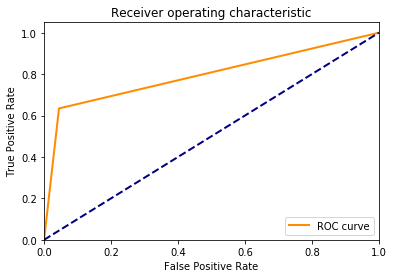

In [47]:

plt.figure()
lw= 2
plt.plot(fpr,  tpr,  color='darkorange' ,lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Model 2 - Gradient Boosted Trees

In [49]:
gb = GradientBoostingClassifier() #using gradient boosted Decision trees
tuned_parameters = [{'n_estimators': [50,100,500],'max_features': ['sqrt', 'log2'],
                     'random_state':[12]}] # grid search, random state set to replicate results
clf_gb = GridSearchCV(gb,tuned_parameters,scoring=scorer, cv=10) #cv only 2 to avoid computational
#expense and time, however larger is recommended if you have computational power and time
clf_gb.fit(xtrain, ytrain)
print("Best parameters set found on development set using Gradient boosting DT:")
print()
print(clf_gb.best_params_)
print("Grid scores on development set using GB:")
print()
means = clf_gb.cv_results_['mean_test_score']
stds = clf_gb.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_gb.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

Best parameters set found on development set using Gradient boosting DT:

{'max_features': 'log2', 'n_estimators': 500, 'random_state': 12}
Grid scores on development set using GB:

0.788 (+/-0.019) for {'max_features': 'sqrt', 'n_estimators': 50, 'random_state': 12}

0.794 (+/-0.018) for {'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 12}

0.799 (+/-0.017) for {'max_features': 'sqrt', 'n_estimators': 500, 'random_state': 12}

0.781 (+/-0.018) for {'max_features': 'log2', 'n_estimators': 50, 'random_state': 12}

0.793 (+/-0.020) for {'max_features': 'log2', 'n_estimators': 100, 'random_state': 12}

0.800 (+/-0.016) for {'max_features': 'log2', 'n_estimators': 500, 'random_state': 12}



### Model 3- Catboost (GBT)

In [53]:
features.columns.get_loc('CITY')

75

In [80]:
from sklearn.model_selection import StratifiedKFold
from sklearn.grid_search import ParameterGrid
from itertools import product, chain
from catboost import CatBoostClassifier
from tqdm import tqdm


RANDOM_STATE = 0

def cross_val(X, y, X_test, param, cat_features, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    acc = []
    predict = None
    
    for tr_ind, val_ind in skf.split(X, y):
        X_train = X.iloc[tr_ind]
        y_train = y.iloc[tr_ind]
        
        X_valid = X.iloc[val_ind]
        y_valid = y.iloc[val_ind]
        
        clf = CatBoostClassifier(iterations=500,
                                loss_function = param['loss_function'],
                                depth=param['depth'],
                                l2_leaf_reg = param['l2_leaf_reg'],
                                eval_metric = 'AUC',
                                leaf_estimation_iterations = 10,
                                use_best_model=True,
                                logging_level='Silent'
        )
        
        clf.fit(X_train, 
                y_train,
                cat_features=cat_features,
                eval_set=(X_valid, y_valid)
        )
        
        y_pred = clf.predict(X_valid)
        accuracy = roc_auc_score(y_valid, y_pred)
        acc.append(accuracy)
    return sum(acc)/n_splits
    
def catboost_GridSearchCV(X, y, X_test, params, cat_features, n_splits=10):
    ps = {'acc':0,
          'param': []
    }
    
    predict=None
    
    for prms in tqdm(list(ParameterGrid(params)), ascii=True, desc='Params Tuning:'):
                          
        acc = cross_val(X, y, X_test, prms, cat_features, n_splits=10)

        if acc>ps['acc']:
            ps['acc'] = acc
            ps['param'] = prms
    print('AUC: '+str(ps['acc']))
    print('Params: '+str(ps['param']))
    
    return ps['param']

In [68]:
merged_removed_all = pd.read_csv(r'D:\hackathon\Data Sciecne Hackathon Dataset\merged_removed_all.csv')
merged_removed_all.reset_index(drop=True, inplace = True)
merged_removed_all.drop(['IDENTITY_ID','Unnamed: 0'], axis=1,inplace = True)
features = merged_removed_all.loc[:, merged_removed_all.columns != 'TARGET_FLAG']
labels = merged_removed_all['TARGET_FLAG']

In [72]:
xtrain.head()

,APPS_DOWNLOAD_APP_HITS,AUDIO_APP_VOLUME,CST,Computer_and_Electronics_volume,EMAIL_APP_VOLUME,E_COMMERCE_APP_HITS,GPRS_SUB_REV,HYBRID_SUB_REV,IM_APP_HITS,IM_APP_VOLUME,...,U_OB_SMS_REV_T6,U_OB_VC_ND_DUR_T6,VAS_SUB_REV,VIDEO_APP_VOLUME,VOIP_APP_HITS,VOIP_APP_VOLUME,WEBBROWSING_APP_HITS,WEBBROWSING_APP_VOLUME,CITY,total_hits
13571,0,0.0,166.70,81.7578,33.7822,29,18.0,337.0,25,105.1504,...,0.000,223.0,258.00,0.0000,0,0.0,280,6190.8587,2,586
17861,0,0.0,0.00,0.0000,0.0000,0,0.0,0.0,0,0.0000,...,0.000,0.0,0.00,0.0000,0,0.0,0,0.0000,17,0
8783,10,0.0,57.95,0.0000,0.0000,9,0.0,100.0,157,495.7186,...,0.000,30.5,18.50,489739.9962,0,0.0,2476,48216.9459,69,5361
17448,0,0.0,6.05,0.0000,0.0000,0,0.0,19.0,0,0.0000,...,0.000,0.0,44.20,0.0000,0,0.0,0,0.0000,106,0
14059,0,0.0,132.98,0.0000,0.0000,0,0.0,0.0,0,0.0000,...,1.792,67.0,14.32,0.0000,0,0.0,0,0.0000,89,2


In [81]:
xtrain,  xtest,  ytrain,  ytest  = \
train_test_split(features, labels, train_size=0.80, random_state=12)


X_train, y_train = xtrain, ytrain
X_test, cat_features = xtest,[75]

params = {'depth':[2, 3, 4],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg':np.logspace(-20, -19, 3)
}

param = catboost_GridSearchCV(X_train, y_train, X_test, params, cat_features)



C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Params Tuning::   0%|                                                                           | 0/18 [00:00<?, ?it/s]

Params Tuning::   6%|###6                                                              | 1/18 [02:25<41:15, 145.64s/it]

Params Tuning::  11%|#######3                                                          | 2/18 [04:41<37:29, 140.58s/it]

Params Tuning::  17%|###########                                                       | 3/18 [06:59<34:57, 139.80s/it]

Params Tuning::  22%|##############6                                                   | 4/18 [09:22<32:48, 140.59s/it]

Params Tuning::  28%|##################3                                               | 5/18 [11:39<30:19, 139.97s/it]

Params Tuning::  33%|#############

AUC: 0.8016243589175831
Params: {'depth': 4, 'l2_leaf_reg': 3.162277660168379e-20, 'loss_function': 'CrossEntropy'}


In [82]:
clf = CatBoostClassifier(iterations=2500,
                        loss_function = param['loss_function'],
                        depth=param['depth'],
                        l2_leaf_reg = param['l2_leaf_reg'],
                        eval_metric = 'AUC',
                        leaf_estimation_iterations = 10,
                        use_best_model=True
)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                    y_train, 
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE,
                                                    train_size=0.8,
                                                    stratify=y_train
)
clf.fit(X_train, 
        y_train,
        cat_features=cat_features,
        logging_level='Silent',
        eval_set=(X_valid, y_valid)
)

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [89]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, ytest, reference=lgb_train)

# train
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval)

gridParams = {
    'learning_rate': [ 0.1,0.01, 0.001],
    'num_leaves': [63,100],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
  
}

mdl = lgb.LGBMClassifier()

scoring = {'AUC': 'roc_auc'}

# Create the grid
clf= GridSearchCV(mdl, gridParams, verbose=2, cv=10, scoring=scoring, n_jobs=-1, refit='AUC')
# Run the grid
clf.fit(X_train, y_train)

print('Best parameters found by grid search are:', clf.best_params_)
print('Best score found by grid search is:', clf.best_score_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.9min finished


Best parameters found by grid search are: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_leaves': 63, 'objective': 'binary'}
Best score found by grid search is: 0.838844924389813


In [90]:
ypred = clf.predict(xtest)
score = roc_auc_score(ytest, ypred, average='micro')
print ('Test Score: %0.3f'%(score))
fpr, tpr, _ = roc_curve(ytest, ypred)
confusion_matrix(ytest, ypred)

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Test Score: 0.787


array([[1874,  143],
       [ 706, 1277]], dtype=int64)

## Ensemble of Models

Since all models show nearly similar performance I would make a voting ensemble of all the models I used above with the best hyperparameter selected with the Grid Search and 10 fold CV.
The model would then be fitted on all the training set.
Ensemble would be reevaluated with 10 fold cv.


In [100]:
# Voting Ensemble for Classification
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

scorer = make_scorer(roc_auc_score, average='micro')
X = features
X = X.values

Y = labels
Y = Y.values

# create the sub models
estimators = []
model1 = RandomForestClassifier(max_features ='auto', n_estimators=500)
estimators.append(('RF', model1))
model2 = GradientBoostingClassifier(max_features='log2', n_estimators= 500, random_state=12)
estimators.append(('GBT', model2))
model3 = RandomForestClassifier(max_features ='auto', n_estimators=500,random_state=21)
estimators.append(('RF2', model3))
# model3 = CatBoostClassifier(iterations=2500,
#                         loss_function = 'CrossEntropy',
#                         depth=4,
#                         l2_leaf_reg = 3.162277660168379e-20,
#                         eval_metric = 'AUC',
#                         leaf_estimation_iterations = 10
#                         )
                            
# estimators.append(('CATBOOST', model3))
# model3 = lgb.LGBMClassifier(boosting_type ='gbdt',learning_rate =0.01,num_leaves =63,objective='binary')
# estimators.append(('lightGBM', model3))
# model5 = RandomForestClassifier(max_features ='auto', n_estimators=500, random_state =21)
# estimators.append(('RF-2', model5))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, Y, cv=10, scoring = scorer)
print(results.mean())

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-pac

0.8006499999999999


## Test Set

Transform Test set and Predict Test set

In [120]:
test_set['ACTIVITY_DATE'] = pd.to_datetime(test_set['ACTIVITY_DATE'] , errors='coerce')
test_set['DAY'] = test_set['ACTIVITY_DATE'].dt.day.astype('int64')
test_set.head()

test_set.set_index('IDENTITY_ID',inplace = True)
columns_values = list(test_set)
columns_values.remove('CITY')
columns_values.remove('DAY')
test_set.head()

test_set_agg = pd.pivot_table(test_set,index=['IDENTITY_ID'],
                   values =columns_values,
                   aggfunc=[np.sum],fill_value=0)
test_set_agg.columns = test_set_agg.columns.droplevel()

test_set_agg.head()

#aggregative nominal feature (city)
from statistics import mode
test_set_agg_2 = pd.pivot_table(test_set,index=['IDENTITY_ID'],
                   values =['CITY'],
                   aggfunc=lambda x: x.mode()[0] if len(x.mode())>1  else x.mode() ,fill_value = 0)
				   
#inner join two frames
test_set_merged = pd.merge(left=test_set_agg, left_index=True,
                  right=test_set_agg_2, right_index=True,
                  how='inner')

#engineered features added
test_set_merged['total_vol'] =test_set_merged[col_to_use_vol].sum(axis = 1)
test_set_merged['total_hits'] =test_set_merged[col_to_use_hits].sum(axis = 1)

test_set_merged.head()

,ANTIVIRUS_APP_HITS,ANTIVIRUS_APP_VOLUME,APPS_DOWNLOAD_APP_HITS,APPS_DOWNLOAD_APP_VOLUME,AUDIO_APP_HITS,AUDIO_APP_VOLUME,Arts_and_Entertainment_Hits,Arts_and_Entertainment_volume,Autos_and_Vehicles_Hits,Autos_and_Vehicles_volume,...,VIDEO_APP_HITS,VIDEO_APP_VOLUME,VOICE_SUBS_REV,VOIP_APP_HITS,VOIP_APP_VOLUME,WEBBROWSING_APP_HITS,WEBBROWSING_APP_VOLUME,CITY,total_vol,total_hits
IDENTITY_ID,,,,,,,,,,,,,,,,,,,,,
398,0,0.0,0,0.0000,0,0.0,0,0.0000,0,0.0,...,0,0.000000e+00,0.0,0,0.0000,0,0.0000,OKARA,0.000000e+00,0
523,0,0.0,0,0.0000,0,0.0,8,38.7510,0,0.0,...,4,5.032300e+00,0.0,0,0.0000,1812,17425.5995,GUJRANWALA,2.104682e+04,3592
1371,0,0.0,102,501044.6707,0,0.0,318,8951.8201,0,0.0,...,1203,1.914153e+06,0.0,25,180.4824,23442,670011.2448,ATTOCK,5.382883e+06,121069
1501,0,0.0,0,0.0000,0,0.0,0,0.0000,0,0.0,...,0,0.000000e+00,0.0,0,0.0000,2,5.1172,KARACHI,5.117200e+00,2
1622,0,0.0,0,0.0000,0,0.0,0,0.0000,0,0.0,...,0,0.000000e+00,18.0,0,0.0000,15,25.2119,NAWABSHAH,2.521190e+01,15


In [121]:
test_set_merged.to_csv(r'D:\hackathon\Data Sciecne Hackathon Dataset\test_set_merged.csv')

In [188]:
test_set_merged['CITY'] = le.transform(test_set_merged['CITY'].astype(str))

In [189]:
ensemble.fit(xtrain, ytrain)
ypred = ensemble.predict(xtest)

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [192]:
acc_en = accuracy_score(ypred,ytest)
auc_en = roc_auc_score(ypred,ytest)
cnf_matrix = confusion_matrix(ypred,ytest)
prec_en = precision_score(ypred,ytest)
rec_en = recall_score(ypred,ytest)

print('accuracy:',acc_en)
print('auc:',auc_en)
print('precision:',prec_en)
print('recall:',rec_en)
print('confusion matrix:',cnf_matrix)

accuracy: 0.79775
auc: 0.8288375689479965
precision: 0.6419566313666163
recall: 0.9278425655976676
confusion matrix: [[1918  710]
 [  99 1273]]


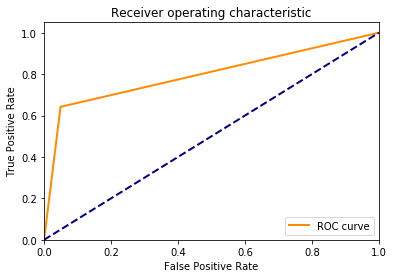

In [194]:
fpr, tpr, _ = roc_curve(ytest, ypred)

plt.figure()
lw= 2
plt.plot(fpr,  tpr,  color='darkorange' ,lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [202]:
ensemble.fit(features,labels)

VotingClassifier(estimators=[('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we...timators=500, n_jobs=1,
            oob_score=False, random_state=21, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [203]:
col_for_test = features.columns.values
ypred_test_set = ensemble.predict(test_set_merged[col_for_test])
submission = test_set_merged
submission['TARGET_FLAG']=ypred_test_set

C:\Users\Muaaz.Sarfaraz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Used excel sheet to vlookup submission files TARGET FLAG to scoring data.csv file for final submission

In [214]:
# test_set_2 = test_set
# test_set_2.set_index('IDENTITY_ID',inplace= True)
# sub_final = pd.merge(left=submission['TARGET_FLAG'], left_index=True,
#                   right=test_set_2['ACTIVITY_DATE'], right_index=True,
#                   how='inner')
# sub_final= sub_final['TARGET_FLAG']
# sub_final.to_csv(r'D:\hackathon\Data Sciecne Hackathon Dataset\sub_final.csv')